## Panorama stitching

#### Ref : https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/

In [7]:
import numpy as np
import cv2

from matplotlib import pyplot as plt

In [2]:
# Feature detection / description
def detectAndDescribe(image):
    # Feature detector / descriptor -- SIFT (On grayscale image)
    # kps : List of keypoint objects
    # features : Descriptors of each keypoint. (#Keypoints, Descriptor dimension=128)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    descriptor = cv2.xfeatures2d.SIFT_create()
    (kps, features) = descriptor.detectAndCompute(image, None)

    # Convert KeyPoint objects to coordinates (#Keypoints, 2)
    kps = np.float32([kp.pt for kp in kps])

    return (kps, features)

In [3]:
# Feature matching
def matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
    # Compute the raw matches (Find best two matching from featuresB for each featuresA)
    # featuresA => Query, featuresB => Train
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

    # Lowe's ratio test over the raw matches
    # Ensure the distance is within a certain ratio of each other
    matches = []    
    for m in rawMatches:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    # Compute homography matrix (Require at least 4 points)
    if len(matches) > 4:
        # Construct the two sets of points (#Matched points, 2)
        ptsA = np.float32([kpsA[i] for (_, i) in matches])
        ptsB = np.float32([kpsB[i] for (i, _) in matches])

        # Compute homography matrix using RANSAC
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

        return (matches, H, status)
    else:
        return None

In [4]:
# Visualization for feature matching
def drawMatches(imageA, imageB, kpsA, kpsB, matches, status):
    # Initialize output image for visualization
    (hA, wA) = imageA.shape[:2]
    (hB, wB) = imageB.shape[:2]
    vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
    vis[0:hA, 0:wA] = imageA
    vis[0:hB, wA:] = imageB

    # Draw lines over the matches
    # (Only draw the match used for homography estimation
    for ((trainIdx, queryIdx), s) in zip(matches, status):
        if s == 1:
            ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
            ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
            cv2.line(vis, ptA, ptB, (0, 255, 0), 1)
 
    return vis

In [5]:
# Panorama stitching
def stitch(images, ratio=0.75, reprojThresh=4.0, showMatches=False):
    # Unpack images
    (imageB, imageA) = images

    # Feature detection & descriptioon
    (kpsA, featuresA) = detectAndDescribe(imageA)
    (kpsB, featuresB) = detectAndDescribe(imageB)

    # Feature matching
    M = matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

    # Return None if there aren't enough matched keypoints to create a panorama
    if M is None:
        return None
    else:
        (matches, H, status) = M

    # Apply warp transformation
    result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))
    result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

    # Return stitched image and feature matching result
    if showMatches:
        vis = drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
        return (result, vis)
    else:
        return result

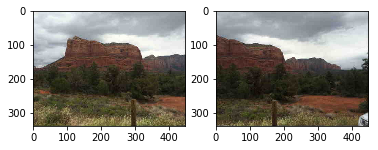

In [10]:
# Load image
imageA = cv2.imread('1.jpg')
imageB = cv2.imread('2.jpg')

for pid, img in enumerate([imageA, imageB]):
    plt.subplot(1, 2, pid + 1)
    plt.imshow(img[..., [2, 1, 0]])

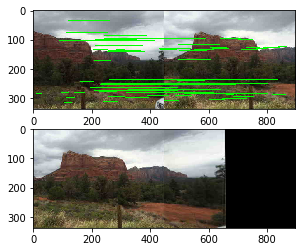

In [13]:
# Panorama stitch
result, vis = stitch([imageA, imageB], showMatches=True)
 
# Show result
for pid, img in enumerate([vis, result]):
    plt.subplot(2, 1, pid + 1)
    plt.imshow(img[..., [2, 1, 0]])